### EMBER 2017 Malware Dataset Overview

**EMBER** (Endgame Malware BEnchmark for Research) is a publicly available dataset released by Endgame (now part of Elastic) in 2018 for training and evaluating machine learning models on portable executable (PE) files.

This dataset contains **pre-extracted static features** from executable files (no raw binaries), which makes it ideal for machine learning experiments without handling potentially malicious files directly.

---

### Dataset Contents

The dataset includes the following files:

* `X_train.jsonl`: Feature representations of \~900,000 training samples
* `X_test.jsonl`: Feature representations of \~200,000 test samples
* `y_train.jsonl`: Binary labels for the training set

  * `1` = Malicious
  * `0` = Benign
* `y_test.jsonl`: Binary labels for the test set
* `metadata.json`: Metadata describing the dataset and feature schema

Each sample in `X_train.jsonl` and `X_test.jsonl` is a JSON object containing various static features extracted from PE files, such as:

* General file metadata (size, entropy)
* Header and section statistics
* Imported/exported functions
* String characteristics
* Byte histogram and byte-entropy histogram

---

### Why Use EMBER?

* No need to handle raw executable binaries
* Large-scale dataset for realistic benchmarking
* Well-documented and designed for research use
* Suitable for static malware detection tasks

---

### Example Use Cases

* Train binary classifiers (malware vs. benign)
* Evaluate feature importance (e.g., using SHAP or LIME)
* Compare traditional ML models (Random Forest, LightGBM) vs. neural models
* Perform feature selection or dimensionality reduction

---

### Notes

* The dataset is quite large (\~2.5 GB).
* No raw binaries are included, only features in JSONL format.
* You can safely work with this dataset in academic or applied research.



In [ ]:
import urllib.request

# Download dataset from Elastic
url = "https://ember.elastic.co/ember_dataset_2017_2.tar.bz2"
output_path = "ember2017_dataset.tar.bz2"
urllib.request.urlretrieve(url, output_path)
print("Download complete.")

# Extract
import tarfile
with tarfile.open(output_path, "r:bz2") as tar:
    tar.extractall("ember_data")
print("Extraction complete.")


Download complete.


In [ ]:
import json
import pandas as pd
import numpy as np

def load_ember_features_with_labels(folder_path, files_prefix="train_features_", file_count=6, limit_per_file=None):
    X_list = []
    y_list = []

    for i in range(file_count):
        file_path = f"{folder_path}/{files_prefix}{i}.jsonl"
        with open(file_path, 'r') as f:
            for j, line in enumerate(f):
                if limit_per_file and j >= limit_per_file:
                    break
                record = json.loads(line)
                label = record.pop("label")  # Remove label from features
                X_list.append(record)
                y_list.append(label)

    df_X = pd.json_normalize(X_list).fillna(0)
    y = pd.Series(y_list)
    return df_X, y

# Load 12,000 samples (2000 from each file)
X_df, y_series = load_ember_features_with_labels("ember_data/ember_2017_2", limit_per_file=2000)

print("Feature shape:", X_df.shape)
print("Label distribution:")
print(y_series.value_counts())


### What Does `label = -1` Mean in the EMBER Dataset?

In the EMBER dataset, the `label` field can take one of the following values:

* `1` — **Malicious**: The file is labeled as malware
* `0` — **Benign**: The file is labeled as non-malicious (clean)
* `-1` — **Unlabeled**: The file does not have a ground truth label

---

### Why Are There `-1` Labels?

* The dataset includes a subset of files with unknown or deliberately withheld labels.
* These unlabeled samples (`-1`) are typically used in **semi-supervised learning** scenarios or for **unsupervised analysis**.
* They simulate real-world conditions where many files are encountered without known classification.

---

### What Should You Do With `-1` Labels?

* If you're training a **binary classifier** (malware vs. benign), you should **exclude all samples with `label = -1`**.
* Only use samples where the label is `0` or `1`.



# Data Exploration - class 0/1

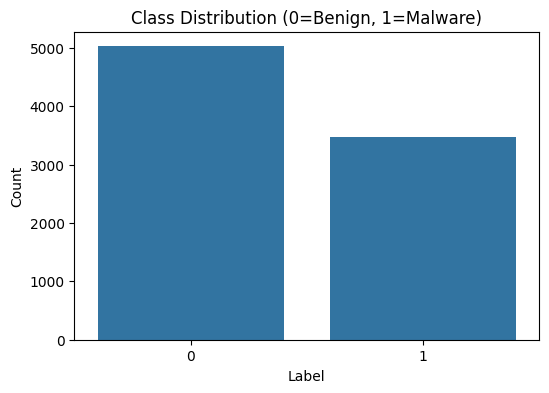

Class Counts:
label
0    5028
1    3470
Name: count, dtype: int64

Malware to Benign Ratio: 0.69


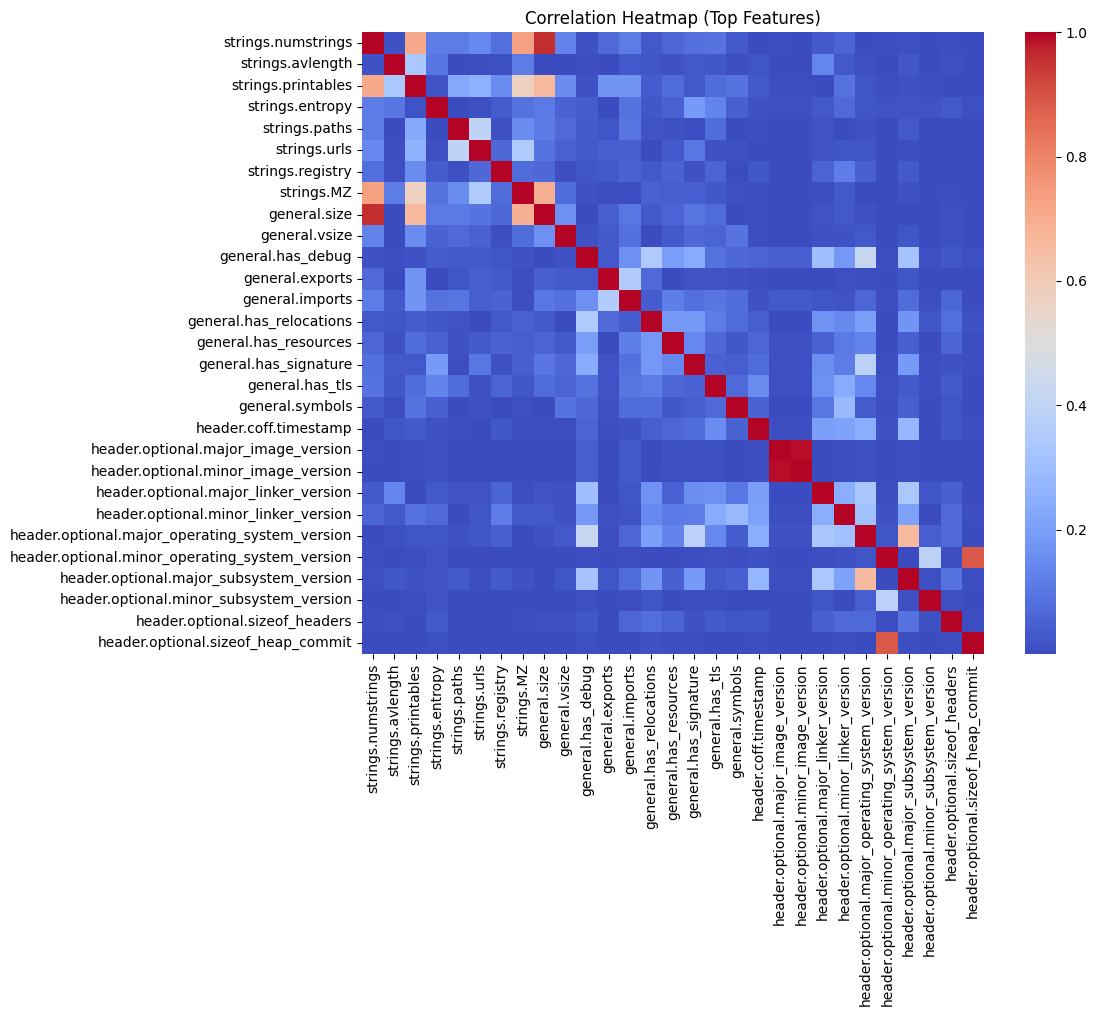

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all train_features_0–5 and extract labeled data only ===
def load_ember_labeled(folder_path, file_count=6, limit_per_file=None):
    features = []
    labels = []
    for i in range(file_count):
        path = f"{folder_path}/train_features_{i}.jsonl"
        with open(path, 'r') as f:
            for j, line in enumerate(f):
                if limit_per_file and j >= limit_per_file:
                    break
                record = json.loads(line)
                label = record.pop("label")
                if label in (0, 1):  # keep only labeled
                    features.append(record)
                    labels.append(label)
    return pd.json_normalize(features).fillna(0), pd.Series(labels)

# Load data (e.g. 2000 per file × 6 = 12,000 samples)
X_df, y_series = load_ember_labeled("/content/ember_data/ember_2017_2", limit_per_file=2000)

# Combine into one DataFrame
df = X_df.copy()
df['label'] = y_series

# === 1. Class Distribution ===
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution (0=Benign, 1=Malware)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("Class Counts:")
print(df['label'].value_counts())
ratio = df['label'].value_counts()[1] / df['label'].value_counts()[0]
print(f"\nMalware to Benign Ratio: {round(ratio, 3)}")

# === 2. File size distribution (if available) ===
if 'general.file_size' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x='general.file_size', hue='label', bins=50, log_scale=True)
    plt.title("File Size Distribution (Log Scale)")
    plt.xlabel("File Size")
    plt.ylabel("Count")
    plt.show()

# === 3. Entropy distribution (if available) ===
if 'general.byte_entropy.mean' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x='general.byte_entropy.mean', hue='label', fill=True)
    plt.title("Byte Entropy Mean Distribution by Class")
    plt.xlabel("Mean Entropy")
    plt.ylabel("Density")
    plt.show()

# === 4. Correlation Heatmap ===
numeric_df = df.select_dtypes(include=['float64', 'int64']).drop(columns='label')
corr = numeric_df.corr().abs()

# Show top correlations only
corr_filtered = corr.loc[corr.sum() > 1.5, corr.sum() > 1.5]  # reduce size
plt.figure(figsize=(12, 10))
sns.heatmap(corr_filtered, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Top Features)")
plt.tight_layout()
plt.show()


# Training 10 classifiers (SKLEARN) on EMBER

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import resample

# === Load train data ===
def load_ember_train(folder_path, prefix="train_features_", file_count=6, limit_per_file=None):
    features, labels = [], []
    for i in range(file_count):
        path = f"{folder_path}/{prefix}{i}.jsonl"
        with open(path, 'r') as f:
            for j, line in enumerate(f):
                if limit_per_file and j >= limit_per_file:
                    break
                record = json.loads(line)
                label = record.pop("label")
                if label in (0, 1):
                    features.append(record)
                    labels.append(label)
    return pd.json_normalize(features).fillna(0), pd.Series(labels)

# === Load test data ===
def load_ember_test(path, limit=None):
    features, labels = [], []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break
            record = json.loads(line)
            label = record.pop("label")
            if label in (0, 1):
                features.append(record)
                labels.append(label)
    return pd.json_normalize(features).fillna(0), pd.Series(labels)

# === Load data ===
train_path = "/content/ember_data/ember_2017_2"
X_train_df, y_train = load_ember_train(train_path, limit_per_file=2000)
X_test_df, y_test = load_ember_test(f"{train_path}/test_features.jsonl", limit=5000)

# Select numeric features only
X_train = X_train_df.select_dtypes(include=[np.number])
X_test = X_test_df.select_dtypes(include=[np.number])

# Align columns
common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# === Apply Undersampling ===
df_train = pd.concat([X_train, y_train.rename("label")], axis=1)
malware_df = df_train[df_train["label"] == 1]
benign_df = df_train[df_train["label"] == 0]

# Undersample benign to match malware
benign_down = resample(benign_df, replace=False, n_samples=len(malware_df), random_state=42)
df_balanced = pd.concat([benign_down, malware_df]).sample(frac=1, random_state=42)

X_train_bal = df_balanced.drop("label", axis=1)
y_train_bal = df_balanced["label"]

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# === Define classifiers ===
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, BaggingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

classifiers = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=0),
    "GradientBoosting": GradientBoostingClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "Bagging": BaggingClassifier(),
    "GaussianNB": GaussianNB(),
    "SVM_RBF": SVC(kernel='rbf'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# === Train and Evaluate ===
for name, model in classifiers.items():
    print(f"\n=== Model: {name} ===")
    model.fit(X_train_scaled, y_train_bal)
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malware"], digits=4))



=== Model: RandomForest ===
              precision    recall  f1-score   support

      Benign     0.9408    0.9584    0.9495      2669
     Malware     0.9513    0.9309    0.9410      2331

    accuracy                         0.9456      5000
   macro avg     0.9461    0.9447    0.9453      5000
weighted avg     0.9457    0.9456    0.9456      5000


=== Model: GradientBoosting ===
              precision    recall  f1-score   support

      Benign     0.8914    0.9284    0.9095      2669
     Malware     0.9140    0.8704    0.8917      2331

    accuracy                         0.9014      5000
   macro avg     0.9027    0.8994    0.9006      5000
weighted avg     0.9019    0.9014    0.9012      5000


=== Model: HistGradientBoosting ===
              precision    recall  f1-score   support

      Benign     0.9394    0.9404    0.9399      2669
     Malware     0.9317    0.9305    0.9311      2331

    accuracy                         0.9358      5000
   macro avg     0.9355    0.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:14:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

      Benign     0.9493    0.9472    0.9482      2669
     Malware     0.9397    0.9421    0.9409      2331

    accuracy                         0.9448      5000
   macro avg     0.9445    0.9446    0.9446      5000
weighted avg     0.9448    0.9448    0.9448      5000



# Evaluate feature importance using SHAP

### Permutation Importance (Scikit-Learn)

**Permutation Importance** is a model-agnostic technique to evaluate the importance of each feature based on its impact on prediction performance.

#### How it works:

* The values of each feature are **randomly shuffled**, one at a time.
* The model's performance is re-evaluated after each shuffle.
* The **drop in accuracy** (or any chosen metric) reflects how important that feature is.
* Features that, when shuffled, cause a large drop in performance are considered **more important**.

#### Advantages:

* Works with **any trained model** (not limited to trees).
* Does not rely on internal model weights.
* More robust than relying solely on built-in `.feature_importances_`.

#### Scikit-Learn Support:

Use `sklearn.inspection.permutation_importance` to compute it directly on validation or test data.

general.has_relocations                           0.06768
general.has_debug                                 0.04974
general.imports                                   0.03190
strings.entropy                                   0.02128
header.coff.timestamp                             0.02078
general.exports                                   0.01604
strings.avlength                                  0.00750
strings.MZ                                        0.00694
header.optional.sizeof_code                       0.00542
general.vsize                                     0.00502
header.optional.major_linker_version              0.00444
header.optional.sizeof_headers                    0.00356
general.size                                      0.00350
header.optional.major_image_version               0.00314
header.optional.minor_operating_system_version    0.00296
header.optional.minor_subsystem_version           0.00248
strings.paths                                     0.00224
strings.printa

<Axes: title={'center': 'Top 20 Features (Permutation Importance)'}>

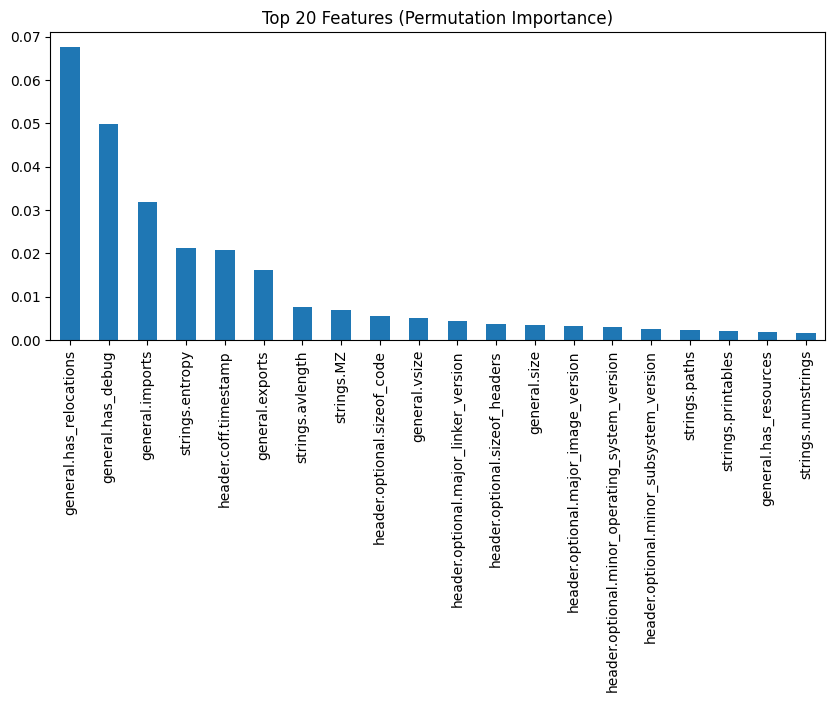

In [ ]:
from sklearn.inspection import permutation_importance

# Train your model first
model.fit(X_train, y_train)

# Run permutation importance on test set
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get top 20 features
importances = pd.Series(result.importances_mean, index=common_cols)
top_20 = importances.sort_values(ascending=False).head(20)
print(top_20)
top_20.plot.bar(figsize=(10,4), title="Top 20 Features (Permutation Importance)")
